## Part 2 — Camera Calibration and AR Cube

This notebook is a **clean, reader-friendly** walkthrough of **Part 2**.

Aligned with the real project code:
- Calibration: `camera.py` → `expand_image_glob`, `calibrate_from_chessboard_images`, `save_calibration_npz`, `load_calibration_npz`
- Cube AR rendering: `ar_render.py` → `make_plane_object_points`, `make_cube_points`, `draw_cube`, `scale_K_to_new_size`
- Tracking (to get 2D corners): `tracker.py` → `PlanarTracker`
- Parameters: `config.py` → `Part2Config`, `Part1Config`

### Goal
1. Estimate camera intrinsics `K` and distortion `dist` from chessboard images.
2. Use the calibrated camera + tracked planar corners to estimate pose (`solvePnP`) and draw a cube.

---

### Setup
Run from inside the `augmented-reality-planar/` folder so relative `data/...` paths resolve.


In [59]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from config import Part1Config, Part2Config
from tracker import PlanarTracker
from camera import expand_image_glob, calibrate_from_chessboard_images, save_calibration_npz, load_calibration_npz
from ar_render import make_plane_object_points, make_cube_points, draw_cube, scale_K_to_new_size

ROOT = Path().resolve()
cfg2 = Part2Config()
tracker_cfg = Part1Config()

print("calib glob:", cfg2.calib_images_glob)
print("calib out:", cfg2.calib_output_path)


calib glob: data/chessboard_jpg/*.[jJ][pP][gG]
calib out: outputs/camera/calibration.npz


### Step 1 — Camera calibration from chessboard images

This calls the **same calibration code** used by `main.py` Part 2.

If you already have `outputs/camera/calibration.npz`, you can skip the calibration cell and just load it.


In [60]:
# Find chessboard images
paths = expand_image_glob(cfg2.calib_images_glob)
print("found", len(paths), "images")

# Run calibration (can take a moment)
calib = calibrate_from_chessboard_images(
    paths,
    pattern_size=(cfg2.chessboard_cols, cfg2.chessboard_rows),
    square_size=cfg2.square_size,
    show_detections=cfg2.show_detections,
)

# Save + reload (mirrors the real pipeline)
calib_out = ROOT / cfg2.calib_output_path
save_calibration_npz(str(calib_out), calib)
calib2 = load_calibration_npz(str(calib_out))

print("saved:", calib_out)
print("image_size (w,h):", calib2.image_size)
print("rms:", calib2.rms)
print("K:\n", calib2.K)
print("dist:", calib2.dist.ravel())


found 53 images
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9465.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9466.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9467.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9533.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9534.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9535.jpg
[calib] skip size mismatch: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\ches

### Step 1b — Visualize calibration images + undistortion

Below we show a few sample chessboard images used for calibration, and one **before/after undistortion** example ("image rectification").


showing 6 calibration images at size (4284, 5712)


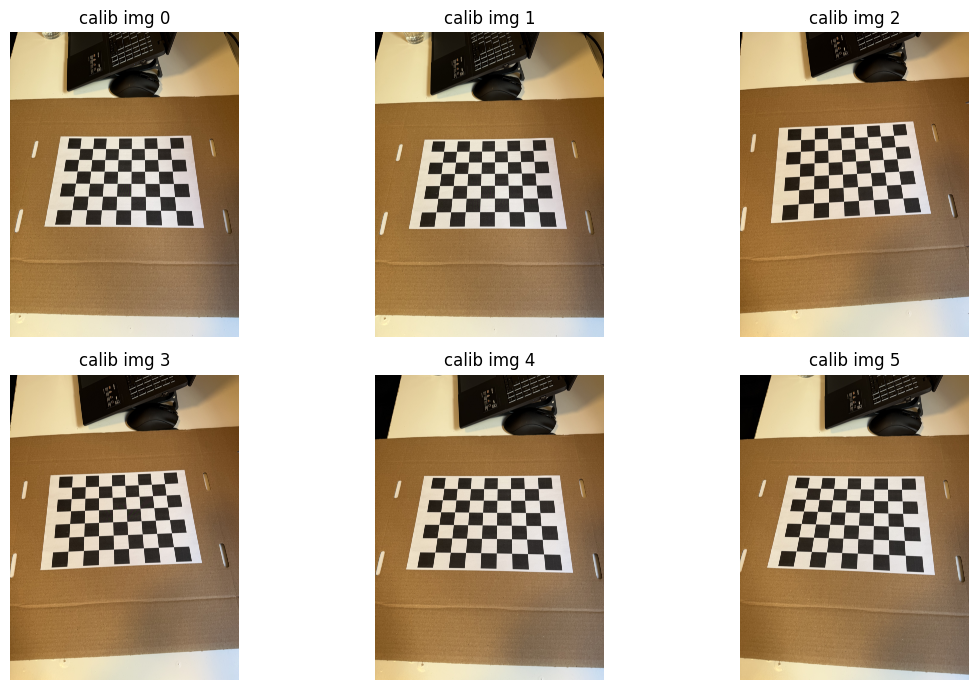

In [61]:
# Show a few calibration images (filtered to the calibration resolution)
img_paths = list(paths)
calib_w, calib_h = tuple(calib2.image_size)

def _imread_any(path: str):
    img = cv2.imread(path)
    if img is not None:
        return img
    try:
        data = np.fromfile(path, dtype=np.uint8)
        if data.size == 0:
            return None
        return cv2.imdecode(data, cv2.IMREAD_COLOR)
    except Exception:
        return None

calib_imgs = []
calib_paths_used = []
for p in img_paths:
    img = _imread_any(p)
    if img is None:
        continue
    h, w = img.shape[:2]
    if (w, h) != (calib_w, calib_h):
        continue
    calib_imgs.append(img)
    calib_paths_used.append(p)
    if len(calib_imgs) >= 6:
        break

print("showing", len(calib_imgs), "calibration images at size", (calib_w, calib_h))

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
ax = ax.reshape(-1)
for i in range(6):
    if i >= len(calib_imgs):
        ax[i].axis("off")
        continue
    ax[i].imshow(cv2.cvtColor(calib_imgs[i], cv2.COLOR_BGR2RGB))
    ax[i].set_title(f"calib img {i}")
    ax[i].axis("off")
plt.tight_layout()


sample path: C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\chessboard_jpg\IMG_9546.jpg


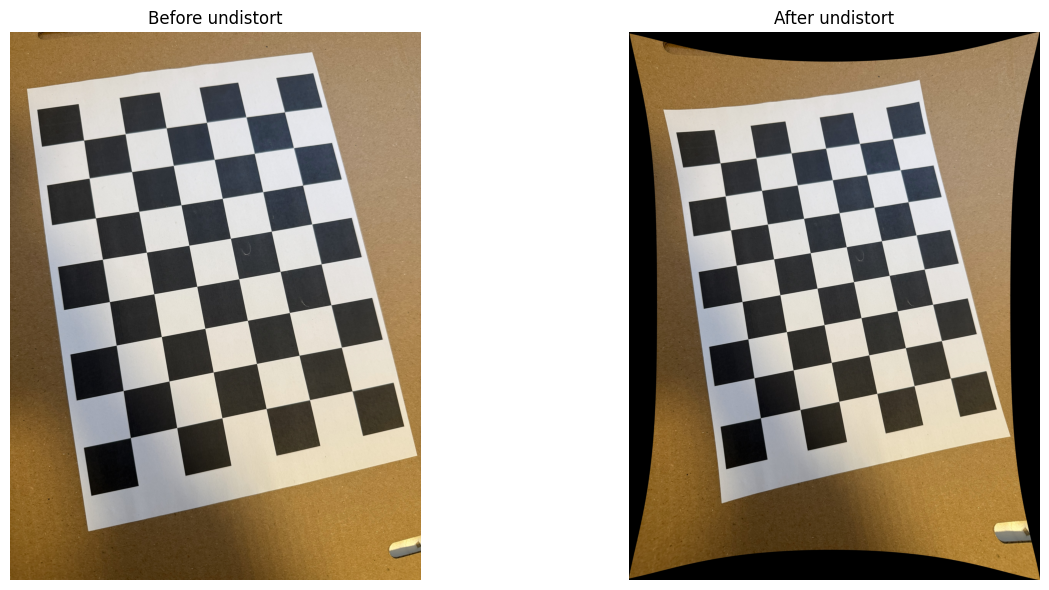

In [62]:
# Example: one calibration image "before/after" undistortion (rectification)

K_calib = np.asarray(calib2.K, dtype=np.float64).reshape(3, 3)
dist_calib = np.asarray(calib2.dist, dtype=np.float64).reshape(-1, 1)

# Try to mimic the style: sample = cv2.imread(img_paths[48])
# but fall back safely if that index is out of range / mismatched size.
preferred_idx = 51
candidates = []
if len(img_paths) > 0:
    candidates.append(min(preferred_idx, len(img_paths) - 1))
    candidates.append(len(img_paths) // 2)
    candidates.append(0)

sample = None
sample_path = None
for idx in candidates:
    p = img_paths[int(idx)]
    img = _imread_any(p)
    if img is None:
        continue
    h, w = img.shape[:2]
    if (w, h) != (calib_w, calib_h):
        continue
    sample = img
    sample_path = p
    break

if sample is None:
    # last resort: find any image with the correct calibration size
    for p in img_paths:
        img = _imread_any(p)
        if img is None:
            continue
        h, w = img.shape[:2]
        if (w, h) == (calib_w, calib_h):
            sample = img
            sample_path = p
            break

assert sample is not None, "Could not load any calibration image matching the calibration size"
print("sample path:", sample_path)

h, w = sample.shape[:2]
newK, _roi = cv2.getOptimalNewCameraMatrix(K_calib, dist_calib, (w, h), 1.0, (w, h))
undist = cv2.undistort(sample, K_calib, dist_calib, None, newK)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
ax[0].set_title("Before undistort")
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
ax[1].set_title("After undistort")
ax[1].axis("off")
plt.tight_layout()


### Step 1c — Visualize detected chessboard corners (one image)

This shows the **inner corners** detected by `cv2.findChessboardCorners` on a single calibration image.


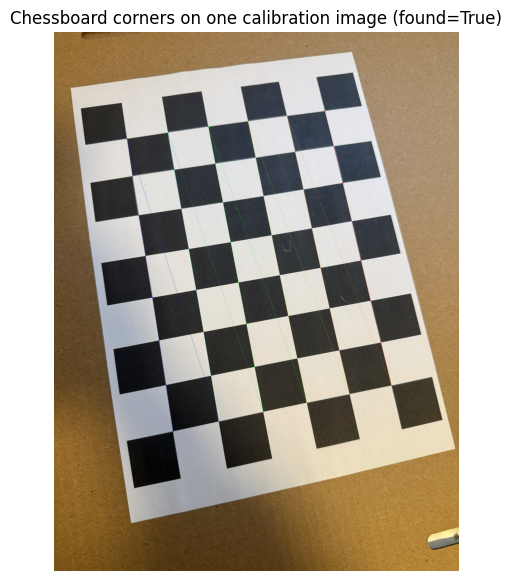

In [63]:
# Pick the same sample image we used above (or any image you like)
img = sample

# Detect corners
pattern_size = (int(cfg2.chessboard_cols), int(cfg2.chessboard_rows))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

find_flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
found, corners = cv2.findChessboardCorners(gray, pattern_size, find_flags)

vis = img.copy()
if found and corners is not None:
    # Sub-pixel refinement (same idea as in camera.py)
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), term)
    cv2.drawChessboardCorners(vis, pattern_size, corners2, found)

plt.figure(figsize=(10, 7))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Chessboard corners on one calibration image (found={found})")
plt.axis("off")
plt.show()


### Step 2 — Load a reference image and one video frame

We’ll run the cube pipeline on **one frame** first (fast + easy to debug).


(1080, 1920, (4284, 5712))

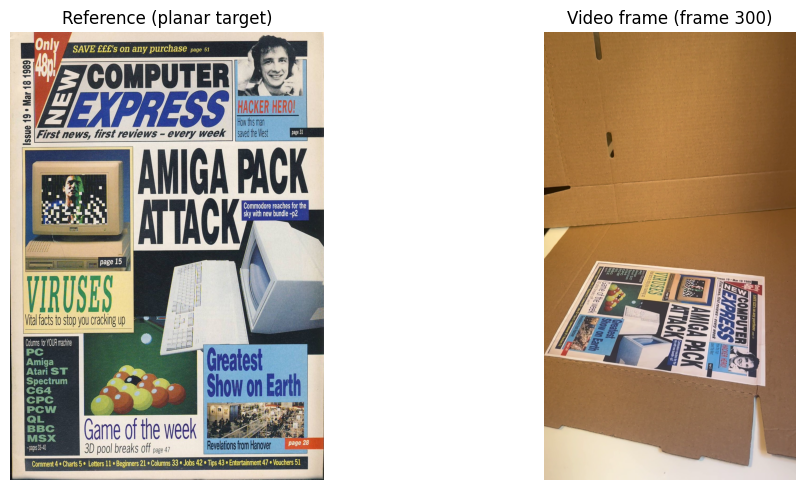

In [64]:
# Load calibration (supports skipping Step 1)
calib_path = ROOT / cfg2.calib_output_path
if "calib2" not in globals():
    calib2 = load_calibration_npz(str(calib_path))

ref_path = ROOT / cfg2.reference_path
video_path = ROOT / cfg2.video_path

# Choose which video frame to use for the cube overlay
frame_idx = 300  # change this (e.g., 120, 250, ...)

ref_bgr = cv2.imread(str(ref_path))
assert ref_bgr is not None, f"Could not read reference: {ref_path}"

cap = cv2.VideoCapture(str(video_path))
assert cap.isOpened(), f"Could not open video: {video_path}"

out_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
ok, frame_bgr = cap.read()
cap.release()
assert ok and frame_bgr is not None, f"Could not read frame {frame_idx}"

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB))
ax[0].set_title("Reference (planar target)")
ax[1].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"Video frame (frame {frame_idx})")
for a in ax:
    a.axis("off")
plt.tight_layout()

(out_w, out_h, calib2.image_size)


### Step 3 — Build `K`/`dist` for this video resolution

Calibration was done at a specific image size. If the video is a different resolution, we **scale `K`** exactly like the code in `main.py`.


In [65]:
K_calib = np.asarray(calib2.K, dtype=np.float64).reshape(3, 3)
dist = np.asarray(calib2.dist, dtype=np.float64).reshape(-1, 1)

K = K_calib
if tuple(calib2.image_size) != (out_w, out_h):
    K = scale_K_to_new_size(K_calib, tuple(calib2.image_size), (out_w, out_h))
K = np.asarray(K, dtype=np.float64).reshape(3, 3)

print("K:\n", K)
print("dist shape:", dist.shape)


K:
 [[1.02087237e+03 0.00000000e+00 5.38220019e+02]
 [0.00000000e+00 1.36038846e+03 9.58303200e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist shape: (5, 1)


### Step 4 — Track the plane and estimate pose (solvePnP)

We:
- track the planar target to get the 4 image corners
- define 4 corresponding object points on a Z=0 plane
- run `cv2.solvePnP` (IPPE if available, otherwise ITERATIVE)
- project and draw a cube using the real rendering utilities (`ar_render.py`)


tracking dbg: {'good': 797, 'inliers': 517, 'held': 0, 'smoothed': 0}


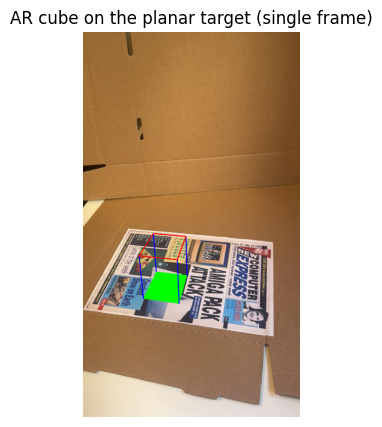

In [66]:
# Track corners (same tracking module as Part 1)
tracker = PlanarTracker(ref_bgr, tracker_cfg)
H, corners, dbg = tracker.track(frame_bgr)
print("tracking dbg:", dbg)

# Build plane object points (Z=0)
ref_h, ref_w = ref_bgr.shape[:2]
ref_aspect = ref_h / float(ref_w)
plane_w = float(cfg2.plane_width)
plane_h = float(cfg2.plane_width) * ref_aspect

obj_plane = np.ascontiguousarray(make_plane_object_points(plane_w, plane_h), dtype=np.float64).reshape(-1, 3)

# Cube geometry (in plane coordinates)
cube_3d = make_cube_points(
    plane_w=plane_w,
    plane_h=plane_h,
    size_frac=cfg2.cube_size_frac,
    offset_x_frac=cfg2.cube_offset_x_frac,
    offset_y_frac=cfg2.cube_offset_y_frac,
    height_frac=cfg2.cube_height_frac,
)

out = frame_bgr.copy()

if corners is not None:
    img_pts = np.asarray(corners, dtype=np.float64).reshape(-1, 2)
    if img_pts.shape == (4, 2) and np.isfinite(img_pts).all():
        ok_pnp = False
        try:
            if hasattr(cv2, "SOLVEPNP_IPPE"):
                try:
                    ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_IPPE))
                except cv2.error:
                    ok_pnp = False
                if not ok_pnp:
                    ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_ITERATIVE))
            else:
                ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_ITERATIVE))
        except cv2.error:
            ok_pnp = False

        if ok_pnp:
            imgpts, _ = cv2.projectPoints(cube_3d, rvec, tvec, K, dist)
            out = draw_cube(out, imgpts.reshape(-1, 2))

# Show result
plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.title("AR cube on the planar target (single frame)")
plt.axis("off")
plt.show()
